# Chart Generation Agent - Demo Notebook

本 Notebook 演示如何使用 Reflection Pattern 构建一个智能图表生成 Agent。

## 工作流程
1. **Generate**: 生成初始图表代码 (V1)
2. **Execute**: 执行代码生成图表
3. **Reflect**: 使用多模态模型审查图表
4. **Regenerate**: 根据反馈生成改进版本 (V2)

---

## 步骤 0: 环境检查与数据加载

In [1]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import re

# 导入自定义工具函数
from utils import (
    load_and_prepare_data,
    make_schema_text,
    get_response,
    encode_image_b64,
    image_anthropic_call,
    image_openai_call,
    ensure_execute_python_tags,
    extract_code_from_tags,
    print_html,
    check_api_keys,
    get_client_for_model
)

print("✅ 导入成功！")

✅ 导入成功！


In [2]:
# 检查 API Keys 配置状态
check_api_keys()

🔑 API Keys Configuration Status:
  ❌ OpenAI
  ❌ Anthropic
  ✅ Qwen
  ✅ Zhipu (GLM)
  ✅ DeepSeek
  ✅ Moonshoot



In [4]:
# 加载数据
csv_path = "coffee_sales.csv"
df = load_and_prepare_data(csv_path)

print(f"📊 数据已加载: {len(df)} 行 x {len(df.columns)} 列")
print_html(df.head(5), title="📋 数据预览 (前5行)")

📊 数据已加载: 3636 行 x 9 列


date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-03-01,06:14,card,ANON-0000-0000-0001,3.87,Latte,1,3,2024
2024-03-01,11:10,card,ANON-0000-0000-0002,3.87,Hot Chocolate,1,3,2024
2024-03-01,11:19,card,ANON-0000-0000-0002,3.87,Hot Chocolate,1,3,2024
2024-03-01,11:37,card,ANON-0000-0000-0003,2.89,Americano,1,3,2024
2024-03-01,12:56,card,ANON-0000-0000-0004,3.87,Latte,1,3,2024


In [5]:
# 查看数据 Schema
schema_text = make_schema_text(df)
print_html(schema_text, title="📐 数据结构 Schema")

## 步骤 1: 生成初始图表代码 (V1)

使用代码生成能力强的模型（如 `qwen3-max` 或 `gpt-4o`）根据用户指令生成 Matplotlib 代码。

In [6]:
# 定义用户指令
user_instruction = "Create a bar chart showing the total sales amount for each coffee type. Sort by sales amount in descending order."

# 配置参数
generation_model = "qwen3-max"  # 也可以使用 "gpt-4o", "glm-4", "deepseek-chat" 等
out_path_v1 = "chart_v1.png"

print(f"🎯 用户指令: {user_instruction}")
print(f"🤖 使用模型: {generation_model}")

🎯 用户指令: Create a bar chart showing the total sales amount for each coffee type. Sort by sales amount in descending order.
🤖 使用模型: qwen3-max


In [7]:
# 构建生成代码的 Prompt
generate_prompt = f"""You are a data visualization expert.

Return your answer *strictly* in this format:

<execute_python>
# valid python code here
</execute_python>

Do not add explanations, only the tags and the code.

The code should create a visualization from a DataFrame 'df' with these columns:
{schema_text}

User instruction: {user_instruction}

Requirements for the code:
1. Assume the DataFrame is already loaded as 'df'.
2. Use matplotlib for plotting.
3. Add clear title, axis labels, and legend if needed.
4. Save the figure as '{out_path_v1}' with dpi=300.
5. Do not call plt.show().
6. Close all plots with plt.close().
7. Add all necessary import python statements

Return ONLY the code wrapped in <execute_python> tags.
"""

# 调用 LLM 生成代码
print("⏳ 正在生成代码...")
response_v1 = get_response(generation_model, generate_prompt, temperature=0)
response_v1 = ensure_execute_python_tags(response_v1)

print("✅ 代码生成完成！")

⏳ 正在生成代码...
✅ 代码生成完成！


In [8]:
# 提取并显示生成的代码
code_v1 = extract_code_from_tags(response_v1)

if not code_v1:
    print("❌ 错误: 未能提取代码")
    print_html(response_v1, title="⚠️ 原始响应")
else:
    print_html(code_v1, title="📝 生成的代码 (V1)")

## 步骤 2: 执行代码并生成图表 (V1)

⏳ 正在执行代码生成图表...
✅ 图表生成成功！



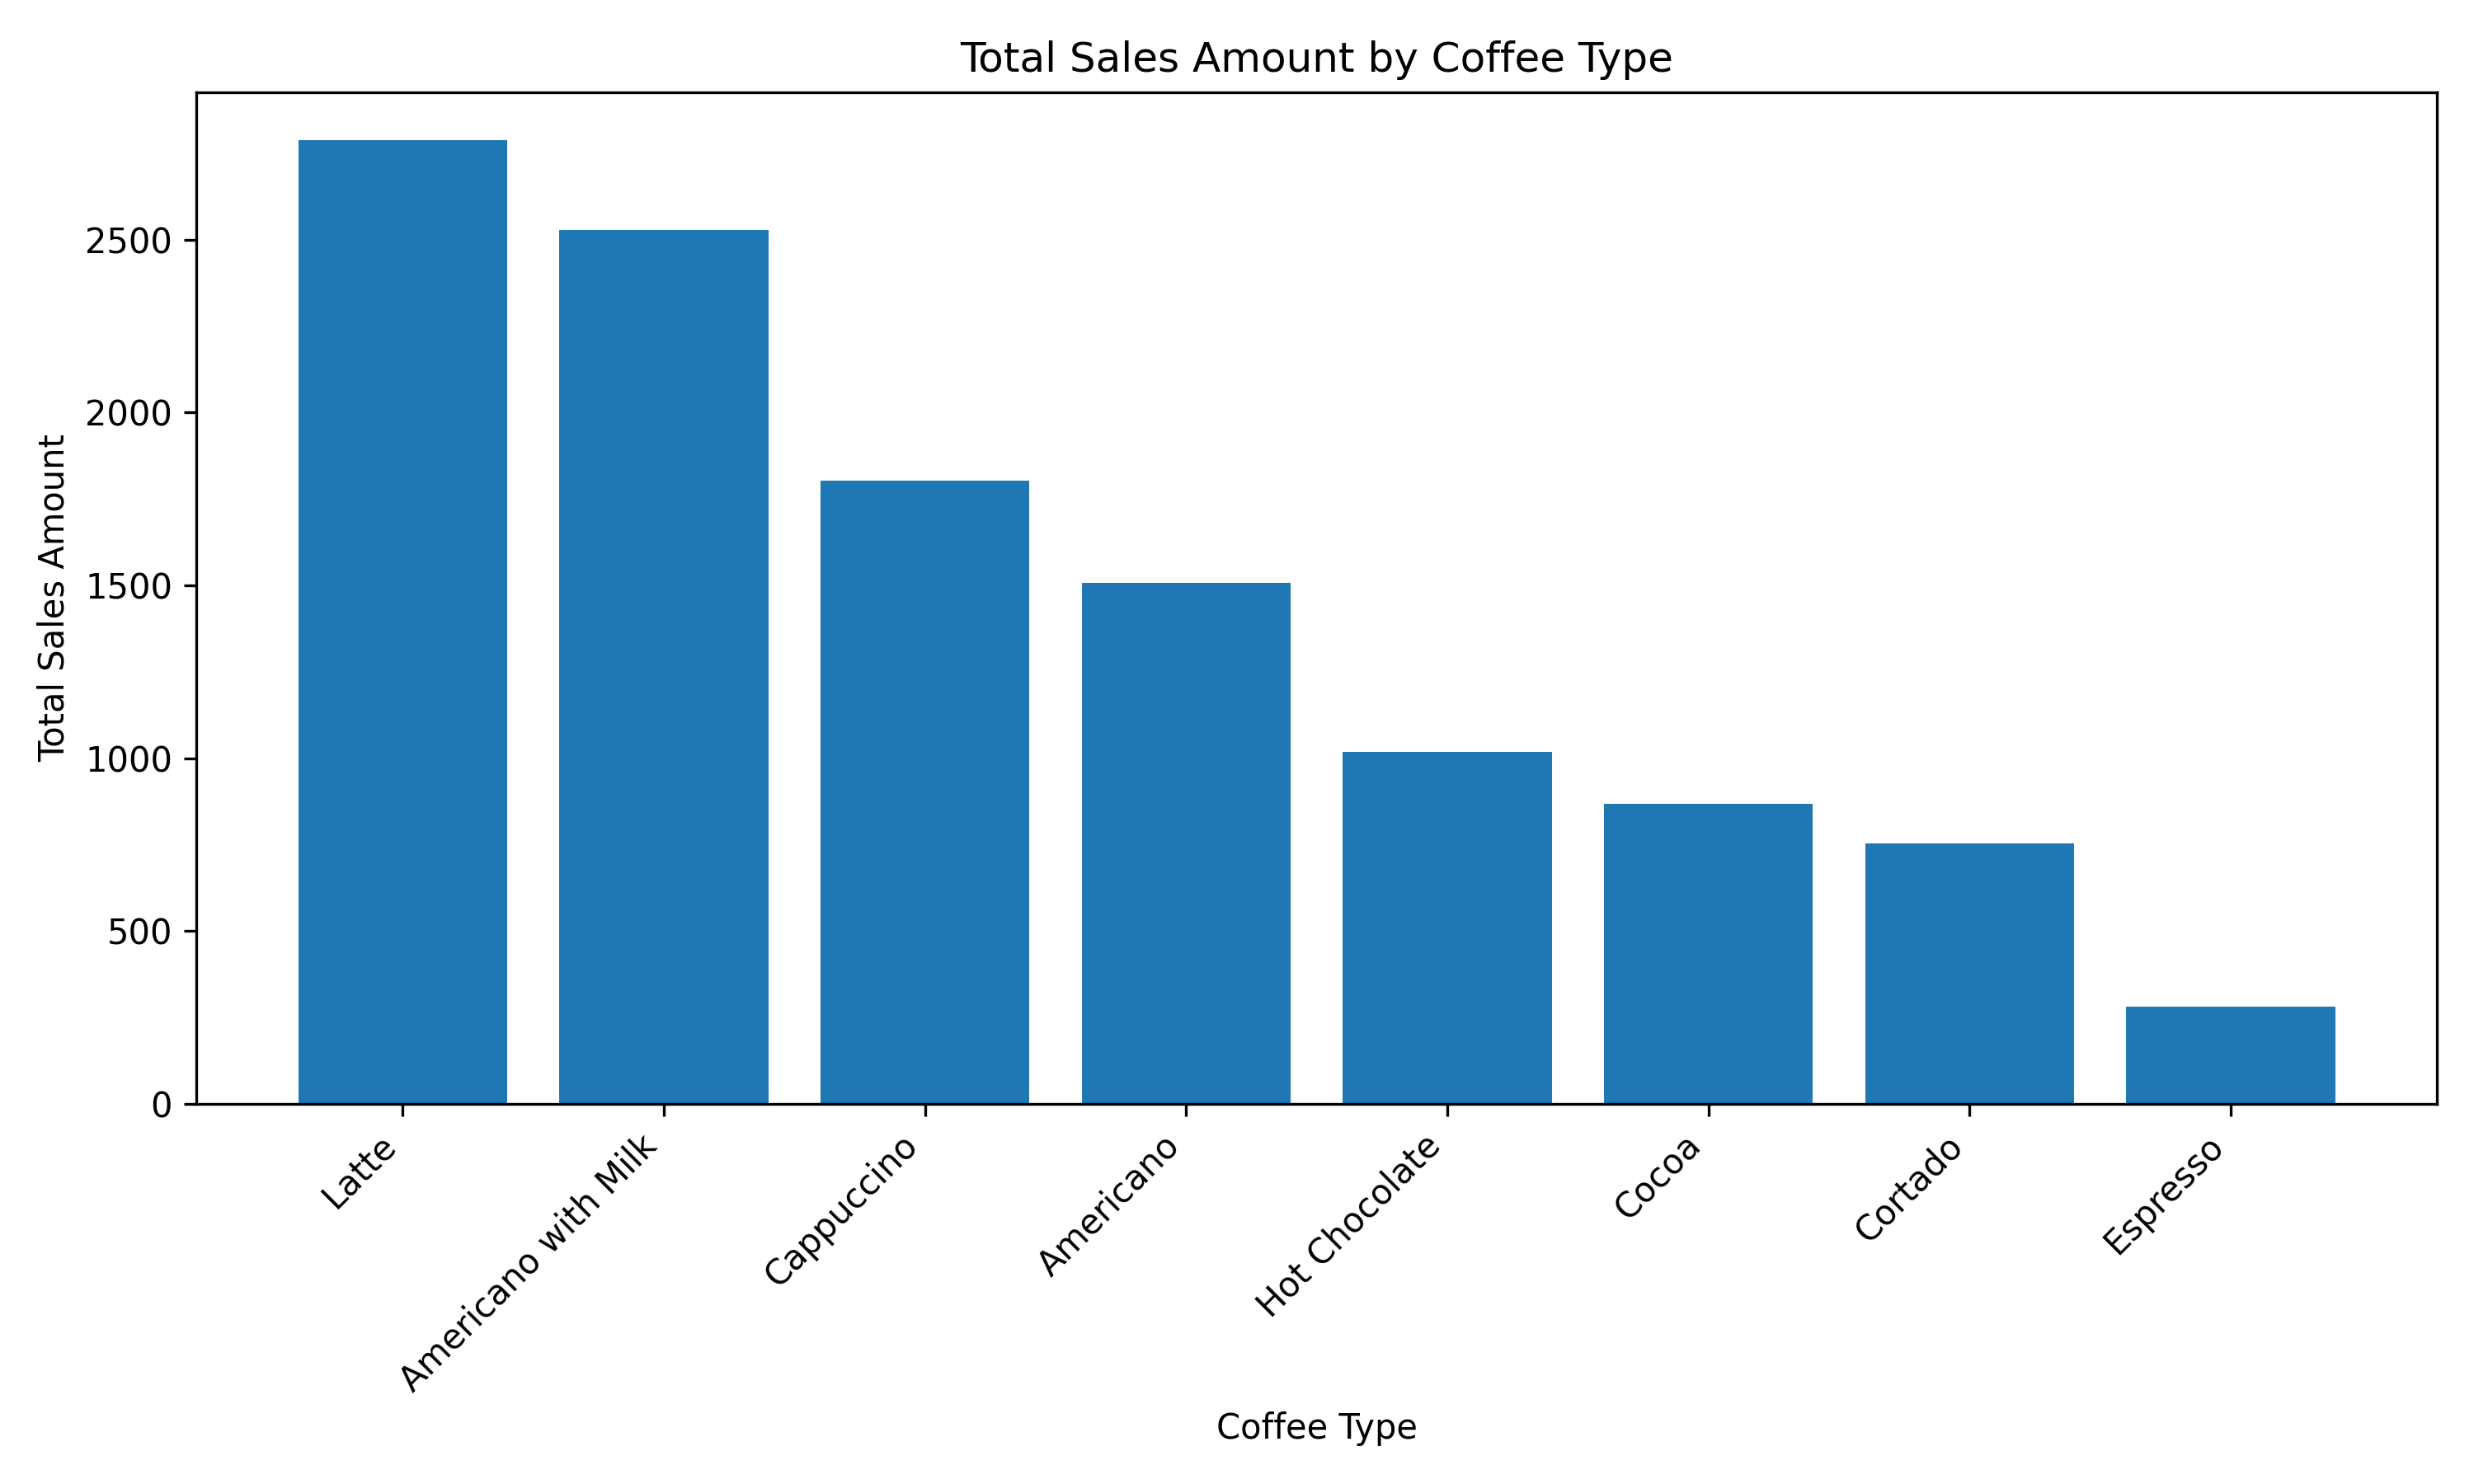

In [9]:
# 执行代码
if code_v1:
    try:
        print("⏳ 正在执行代码生成图表...")
        exec(code_v1, {"df": df, "pd": pd, "plt": plt})
        print("✅ 图表生成成功！")
        
        # 显示图表
        if Path(out_path_v1).exists():
            print_html(out_path_v1, title="📊 图表 V1", is_image=True)
        else:
            print(f"⚠️ 警告: 图表文件 {out_path_v1} 未生成")
    except Exception as e:
        print(f"❌ 执行错误: {e}")
        import traceback
        print(traceback.format_exc())

## 步骤 3: 多模态反思 (Reflection)

使用具备视觉能力的模型（如 `glm-4v`, `qwen-vl-plus`）审查图表，提供改进建议。

In [10]:
# 配置反思模型
reflection_model = "glm-4v"  # 也可以使用 "qwen-vl-plus", "gpt-4o", "claude-3-5-sonnet-20241022" 等
out_path_v2 = "chart_v2.png"

print(f"🔍 使用反思模型: {reflection_model}")

🔍 使用反思模型: glm-4v


In [11]:
# 编码图片为 Base64
if not Path(out_path_v1).exists():
    print(f"❌ 错误: 找不到图表文件 {out_path_v1}")
else:
    media_type, b64_image = encode_image_b64(out_path_v1)
    print(f"✅ 图片已编码 (类型: {media_type})")

✅ 图片已编码 (类型: image/png)


In [12]:
# 构建反思 Prompt
reflect_prompt = f"""You are a data visualization expert.
Your task: critique the attached chart and the original code against the given instruction,
then return improved matplotlib code.

Original code (for context):
{code_v1}

OUTPUT FORMAT (STRICT!):
1) First line: a valid JSON object with ONLY the "feedback" field.
Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

2) After a newline, output ONLY the refined Python code wrapped in:
<execute_python>
...
</execute_python>

3) Import all necessary libraries in the code. Don't assume any imports from the original code.

HARD CONSTRAINTS:
- Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
- Use pandas/matplotlib only (no seaborn).
- Assume df already exists; do not read from files.
- Save to '{out_path_v2}' with dpi=300.
- Always call plt.close() at the end (no plt.show()).
- Include all necessary import statements.

Schema (columns available in df):
{schema_text}

Instruction:
{user_instruction}
"""

# 调用多模态 API
print("⏳ 正在进行多模态反思...")

if "claude" in reflection_model.lower():
    response_v2 = image_anthropic_call(reflection_model, reflect_prompt, media_type, b64_image)
else:
    response_v2 = image_openai_call(reflection_model, reflect_prompt, media_type, b64_image)

print("✅ 反思完成！")

⏳ 正在进行多模态反思...
✅ 反思完成！


In [13]:
# 解析反馈和改进代码
lines = response_v2.strip().split('\n', 1)
feedback_line = lines[0].strip()

# 提取 feedback
try:
    # 尝试从 JSON 中提取
    feedback_json = json.loads(feedback_line)
    feedback = feedback_json.get("feedback", "No feedback provided")
except:
    # 如果不是 JSON，直接使用原始文本
    feedback = feedback_line

# 提取改进后的代码
remaining_text = lines[1] if len(lines) > 1 else response_v2
remaining_text = ensure_execute_python_tags(remaining_text)
code_v2 = extract_code_from_tags(remaining_text)

# 显示反馈
print_html(feedback, title="💬 模型反馈 (Reflection)")

# 显示改进后的代码
if code_v2:
    print_html(code_v2, title="📝 改进后的代码 (V2)")
else:
    print("⚠️ 警告: 未能提取改进后的代码")
    print_html(response_v2, title="⚠️ 原始响应")

## 步骤 4: 执行改进后的代码 (V2)

⏳ 正在执行改进后的代码...
✅ 图表生成成功！



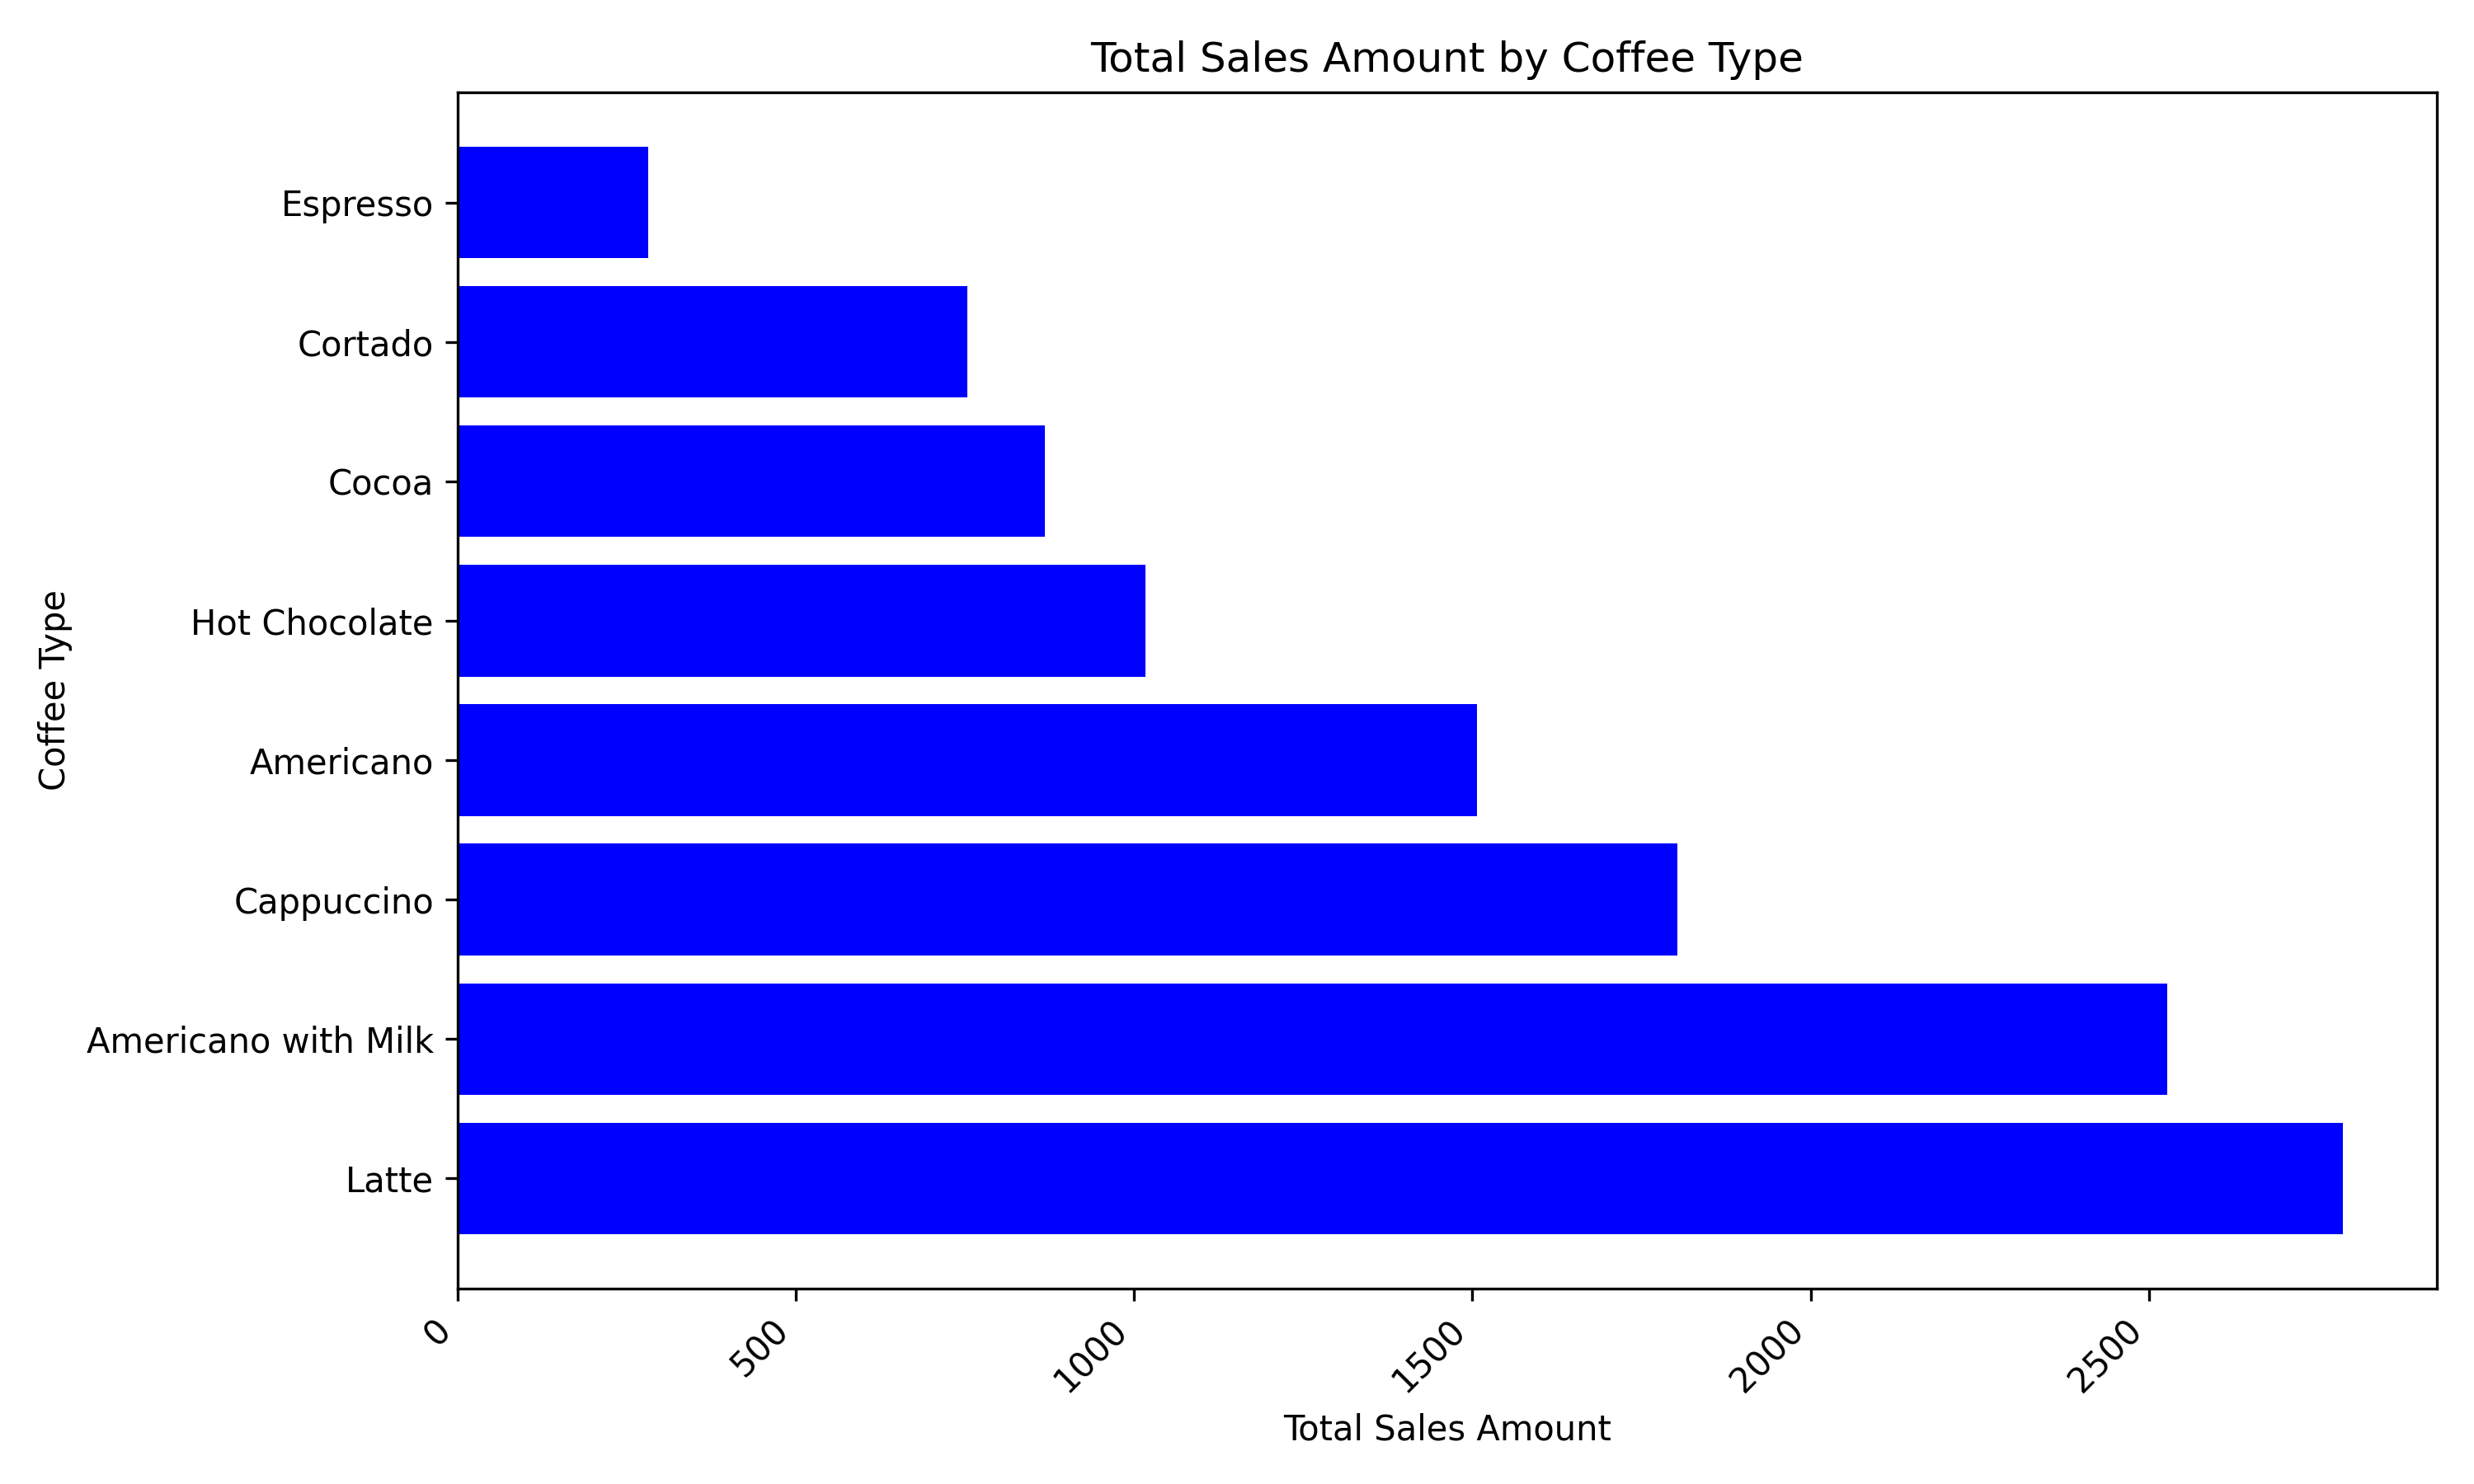

In [14]:
# 执行改进后的代码
if code_v2:
    try:
        print("⏳ 正在执行改进后的代码...")
        exec(code_v2, {"df": df, "pd": pd, "plt": plt})
        print("✅ 图表生成成功！")
        
        # 显示改进后的图表
        if Path(out_path_v2).exists():
            print_html(out_path_v2, title="📊 图表 V2 (改进版)", is_image=True)
        else:
            print(f"⚠️ 警告: 图表文件 {out_path_v2} 未生成")
    except Exception as e:
        print(f"❌ 执行错误: {e}")
        import traceback
        print(traceback.format_exc())

## 步骤 5: 对比展示

并排展示 V1 和 V2 图表，直观对比改进效果。


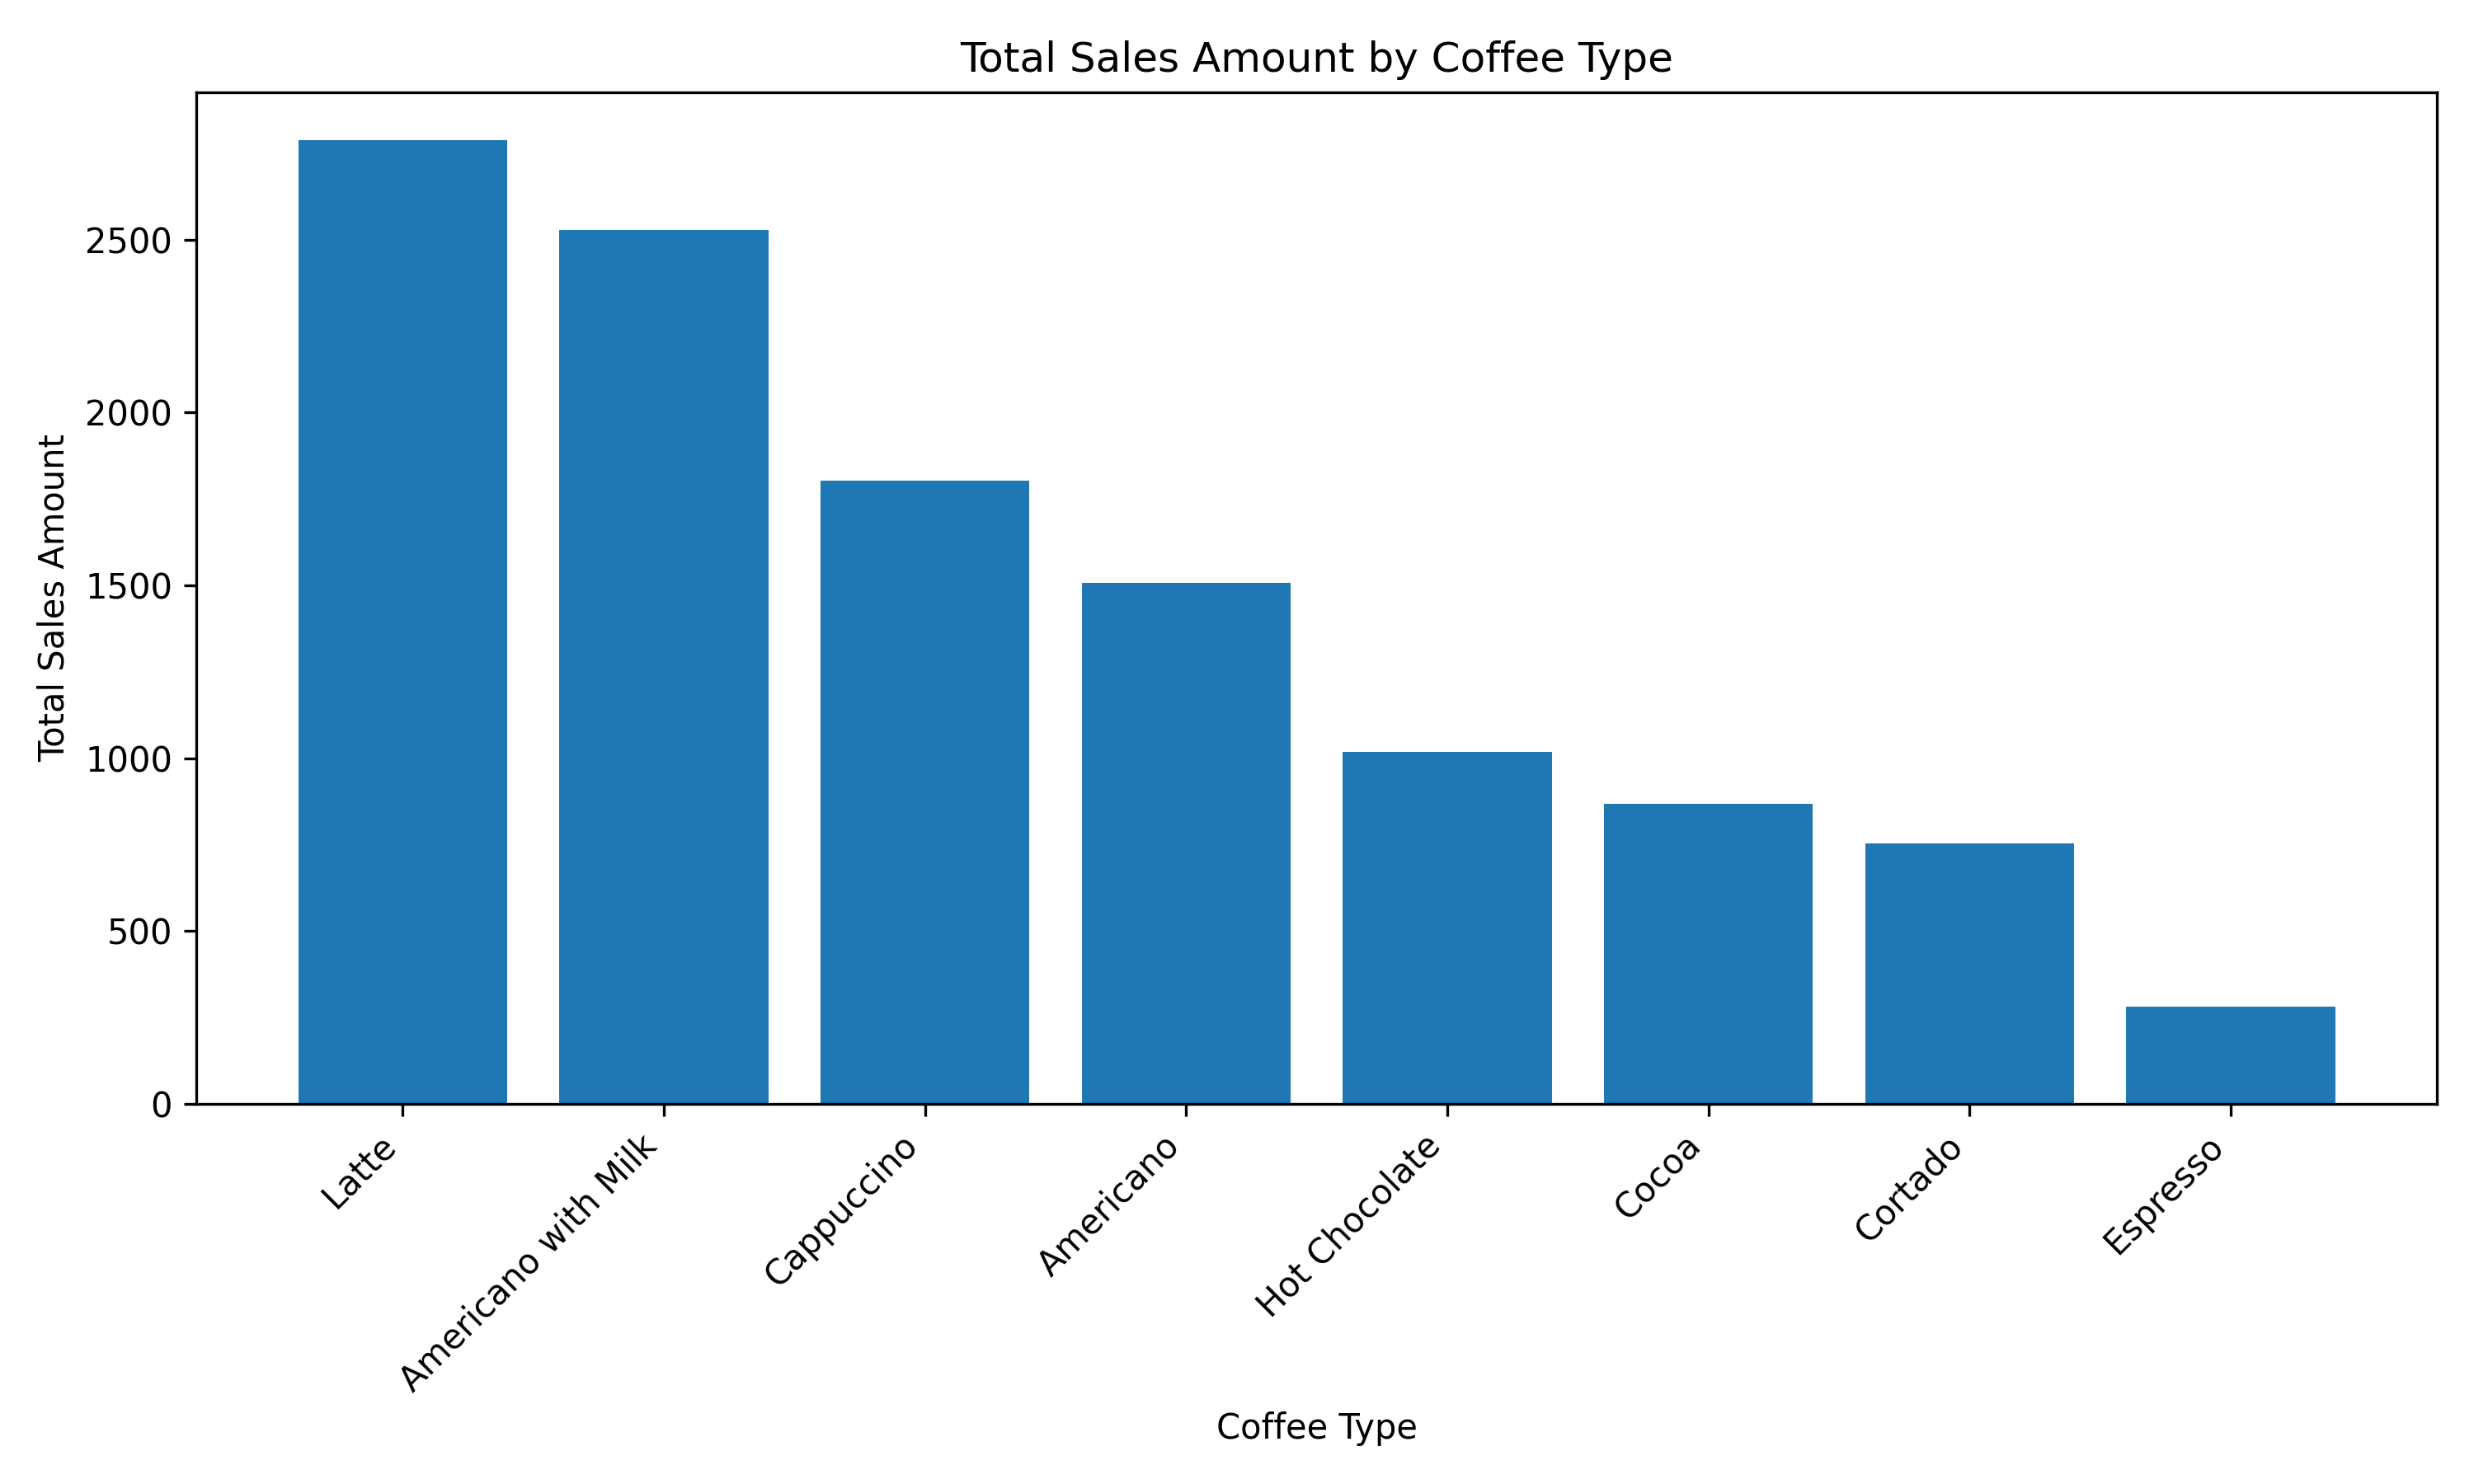
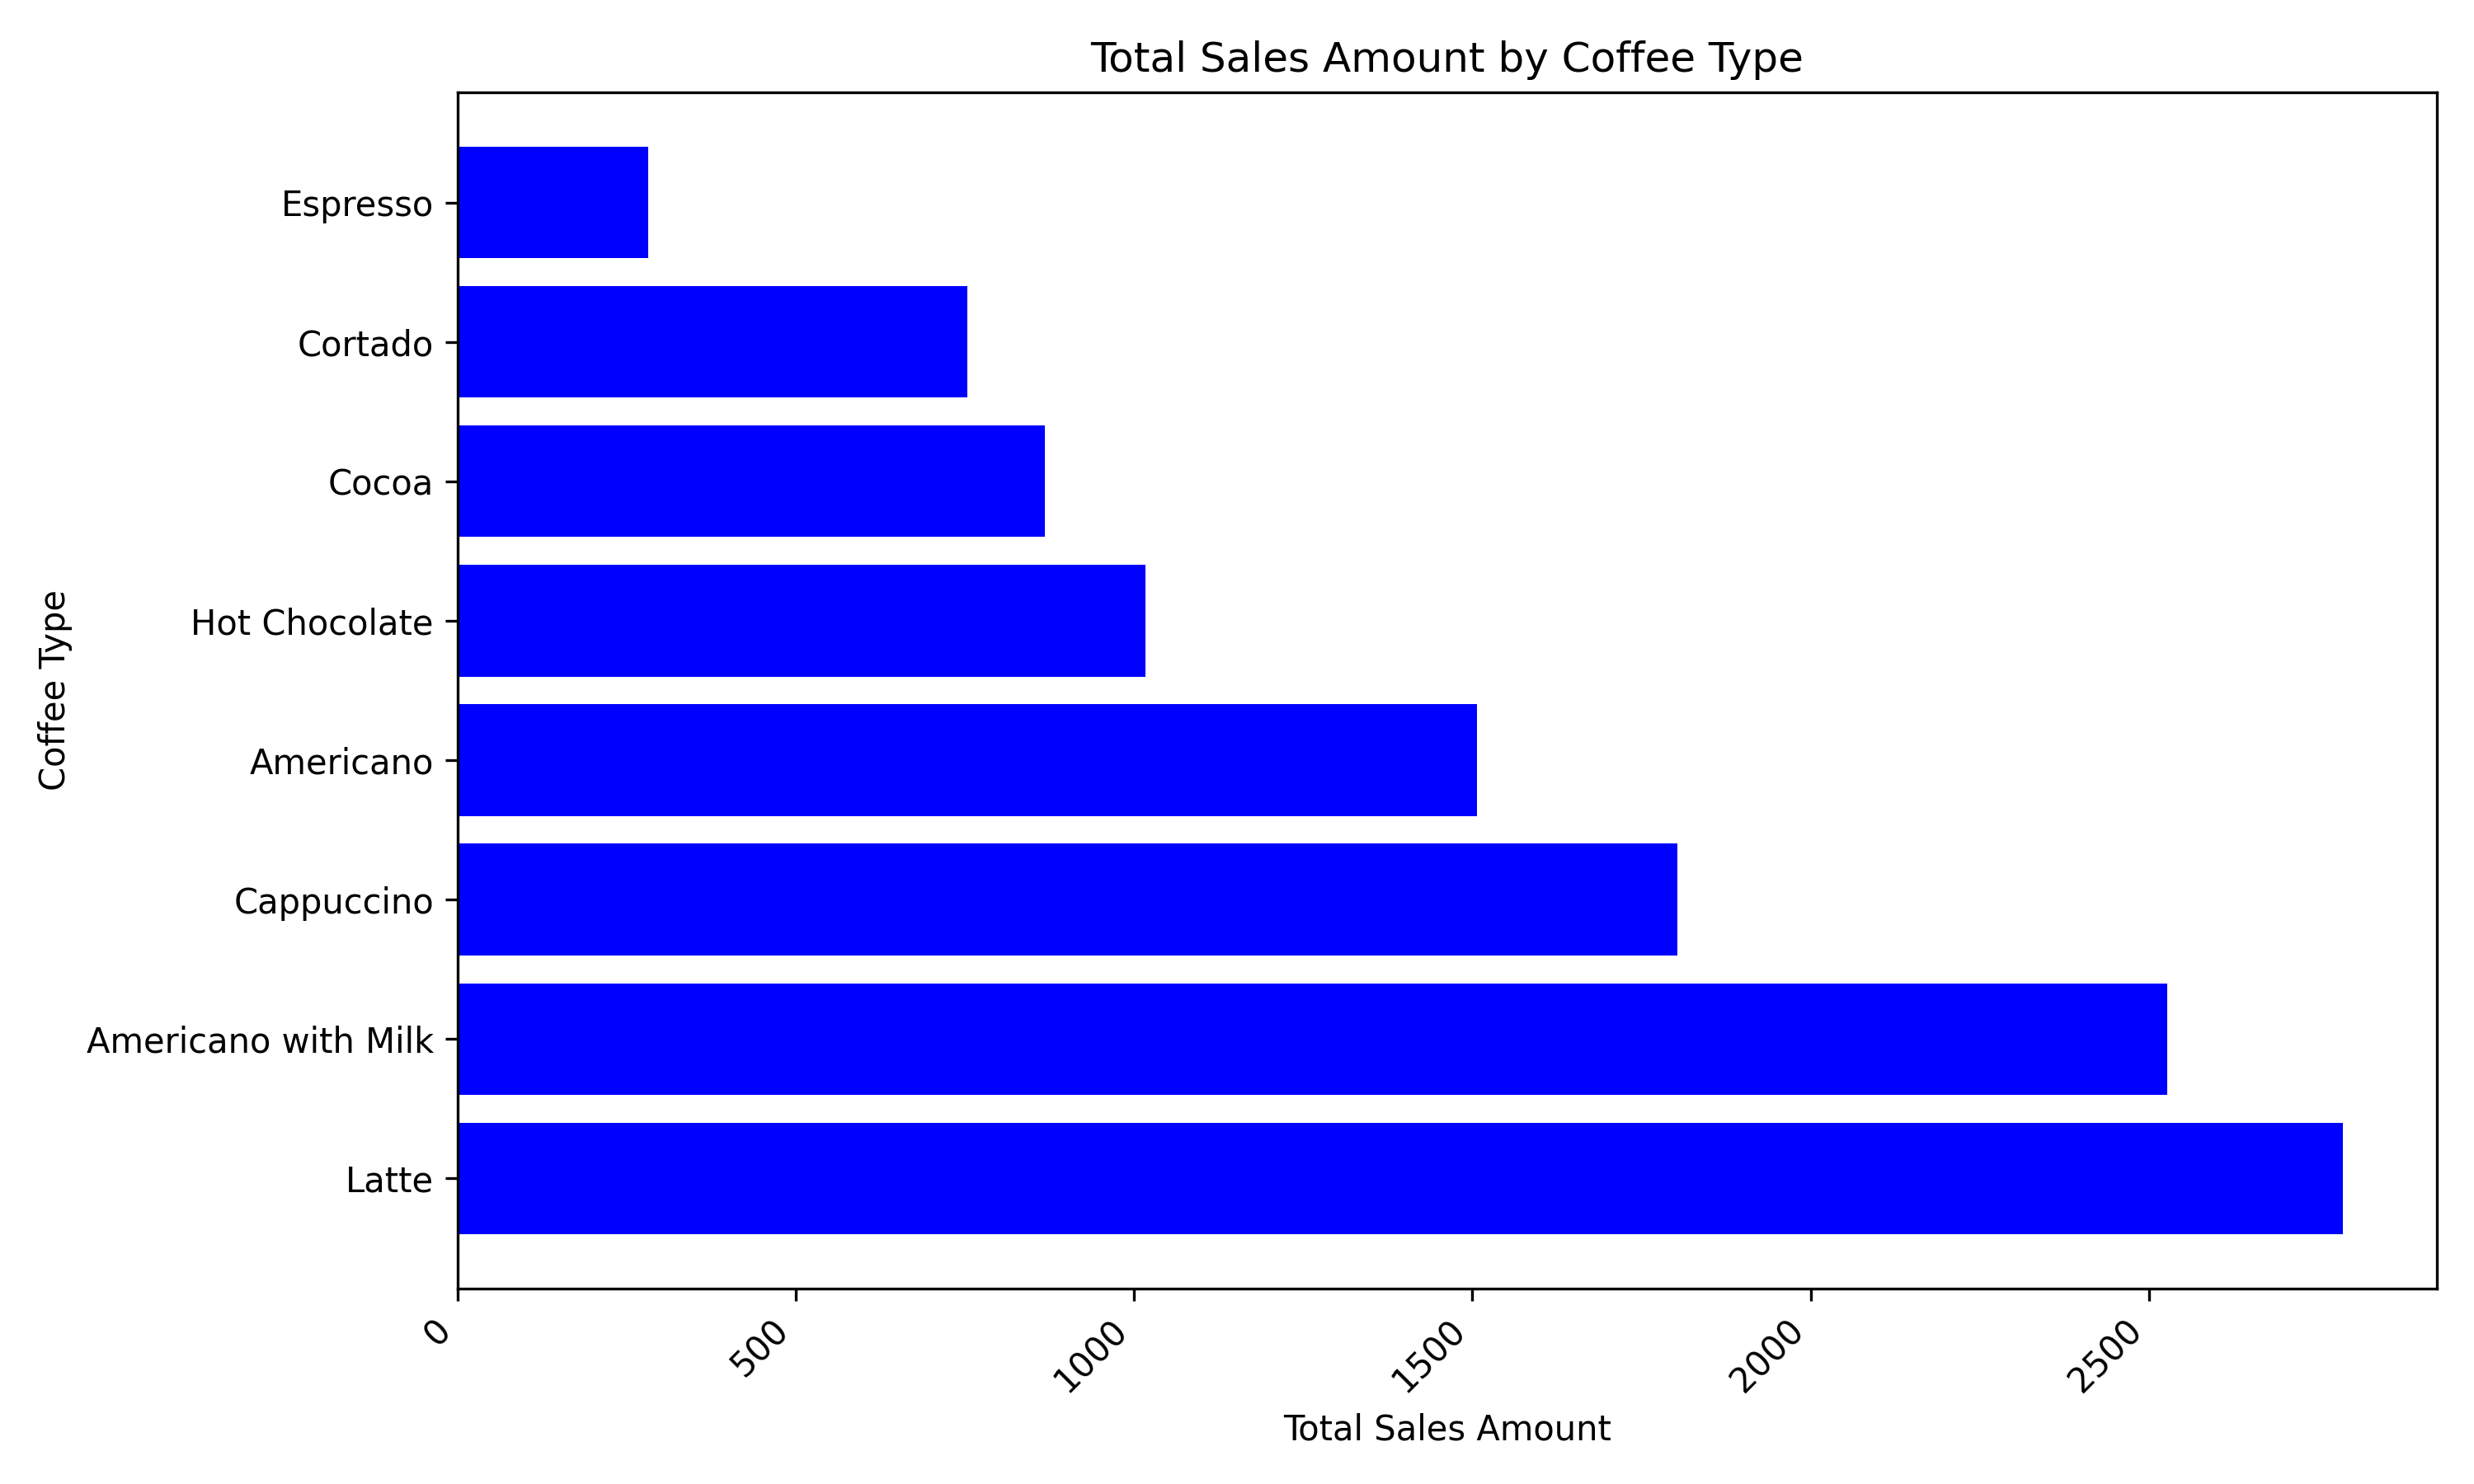

In [15]:
from IPython.display import HTML, display
import base64

def image_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

if Path(out_path_v1).exists() and Path(out_path_v2).exists():
    b64_v1 = image_to_base64(out_path_v1)
    b64_v2 = image_to_base64(out_path_v2)
    
    html = f"""
    <div style="display: flex; gap: 20px; justify-content: center; align-items: flex-start;">
        <div style="text-align: center;">
            <h3 style="color: #3b82f6;">📊 V1 (初始版本)</h3>
            <img src="data:image/png;base64,{b64_v1}" style="max-width: 100%; border: 2px solid #3b82f6; border-radius: 8px;">
        </div>
        <div style="text-align: center;">
            <h3 style="color: #9333ea;">📊 V2 (改进版本)</h3>
            <img src="data:image/png;base64,{b64_v2}" style="max-width: 100%; border: 2px solid #9333ea; border-radius: 8px;">
        </div>
    </div>
    """
    display(HTML(html))
else:
    print("⚠️ 无法进行对比：部分图表文件缺失")

## 🎉 总结

本 Notebook 演示了完整的 Reflection Pattern 工作流：

1. ✅ **Generate**: 使用代码生成模型创建初始图表
2. ✅ **Execute**: 执行代码并生成可视化
3. ✅ **Reflect**: 多模态模型审查图表质量
4. ✅ **Regenerate**: 根据反馈生成改进版本

### 关键技术点
- 🎯 **多供应商支持**: 透明代理模式支持 OpenAI、Qwen、GLM、DeepSeek、Kimi
- 🔍 **多模态反思**: 利用 VLM 发现视觉问题
- 🎨 **美化输出**: 简易沙盒 UI 提升调试体验
- 🛡️ **鲁棒性**: 防御性编程处理各种边界情况

---
*Demo Created: 2025-12-14*

## 🧪 实验区：尝试不同的指令

你可以在下面的单元格中尝试不同的可视化指令：

In [ ]:
# 示例指令（可以修改）
custom_instruction = "Create a line chart showing the trend of daily total sales over time"

# TODO: 复用上面的代码执行自定义指令
print(f"🎯 自定义指令: {custom_instruction}")
print("💡 提示: 复制上面的代码单元格来执行此指令")

## 🚀 快速使用：一键运行完整工作流

使用封装好的 `run_workflow` 函数，一行代码执行完整的 Reflection Pattern！

📊 步骤 1/6: 加载数据...
   ✅ 数据已加载: 3636 行 x 9 列

🤖 步骤 2/6: 使用 qwen3-max 生成初始代码...
   ✅ 代码生成成功
   ✅ 代码生成成功



⚙️ 步骤 3/6: 执行代码生成图表 V1...
   ✅ 图表 V1 生成成功
   ✅ 图表 V1 生成成功



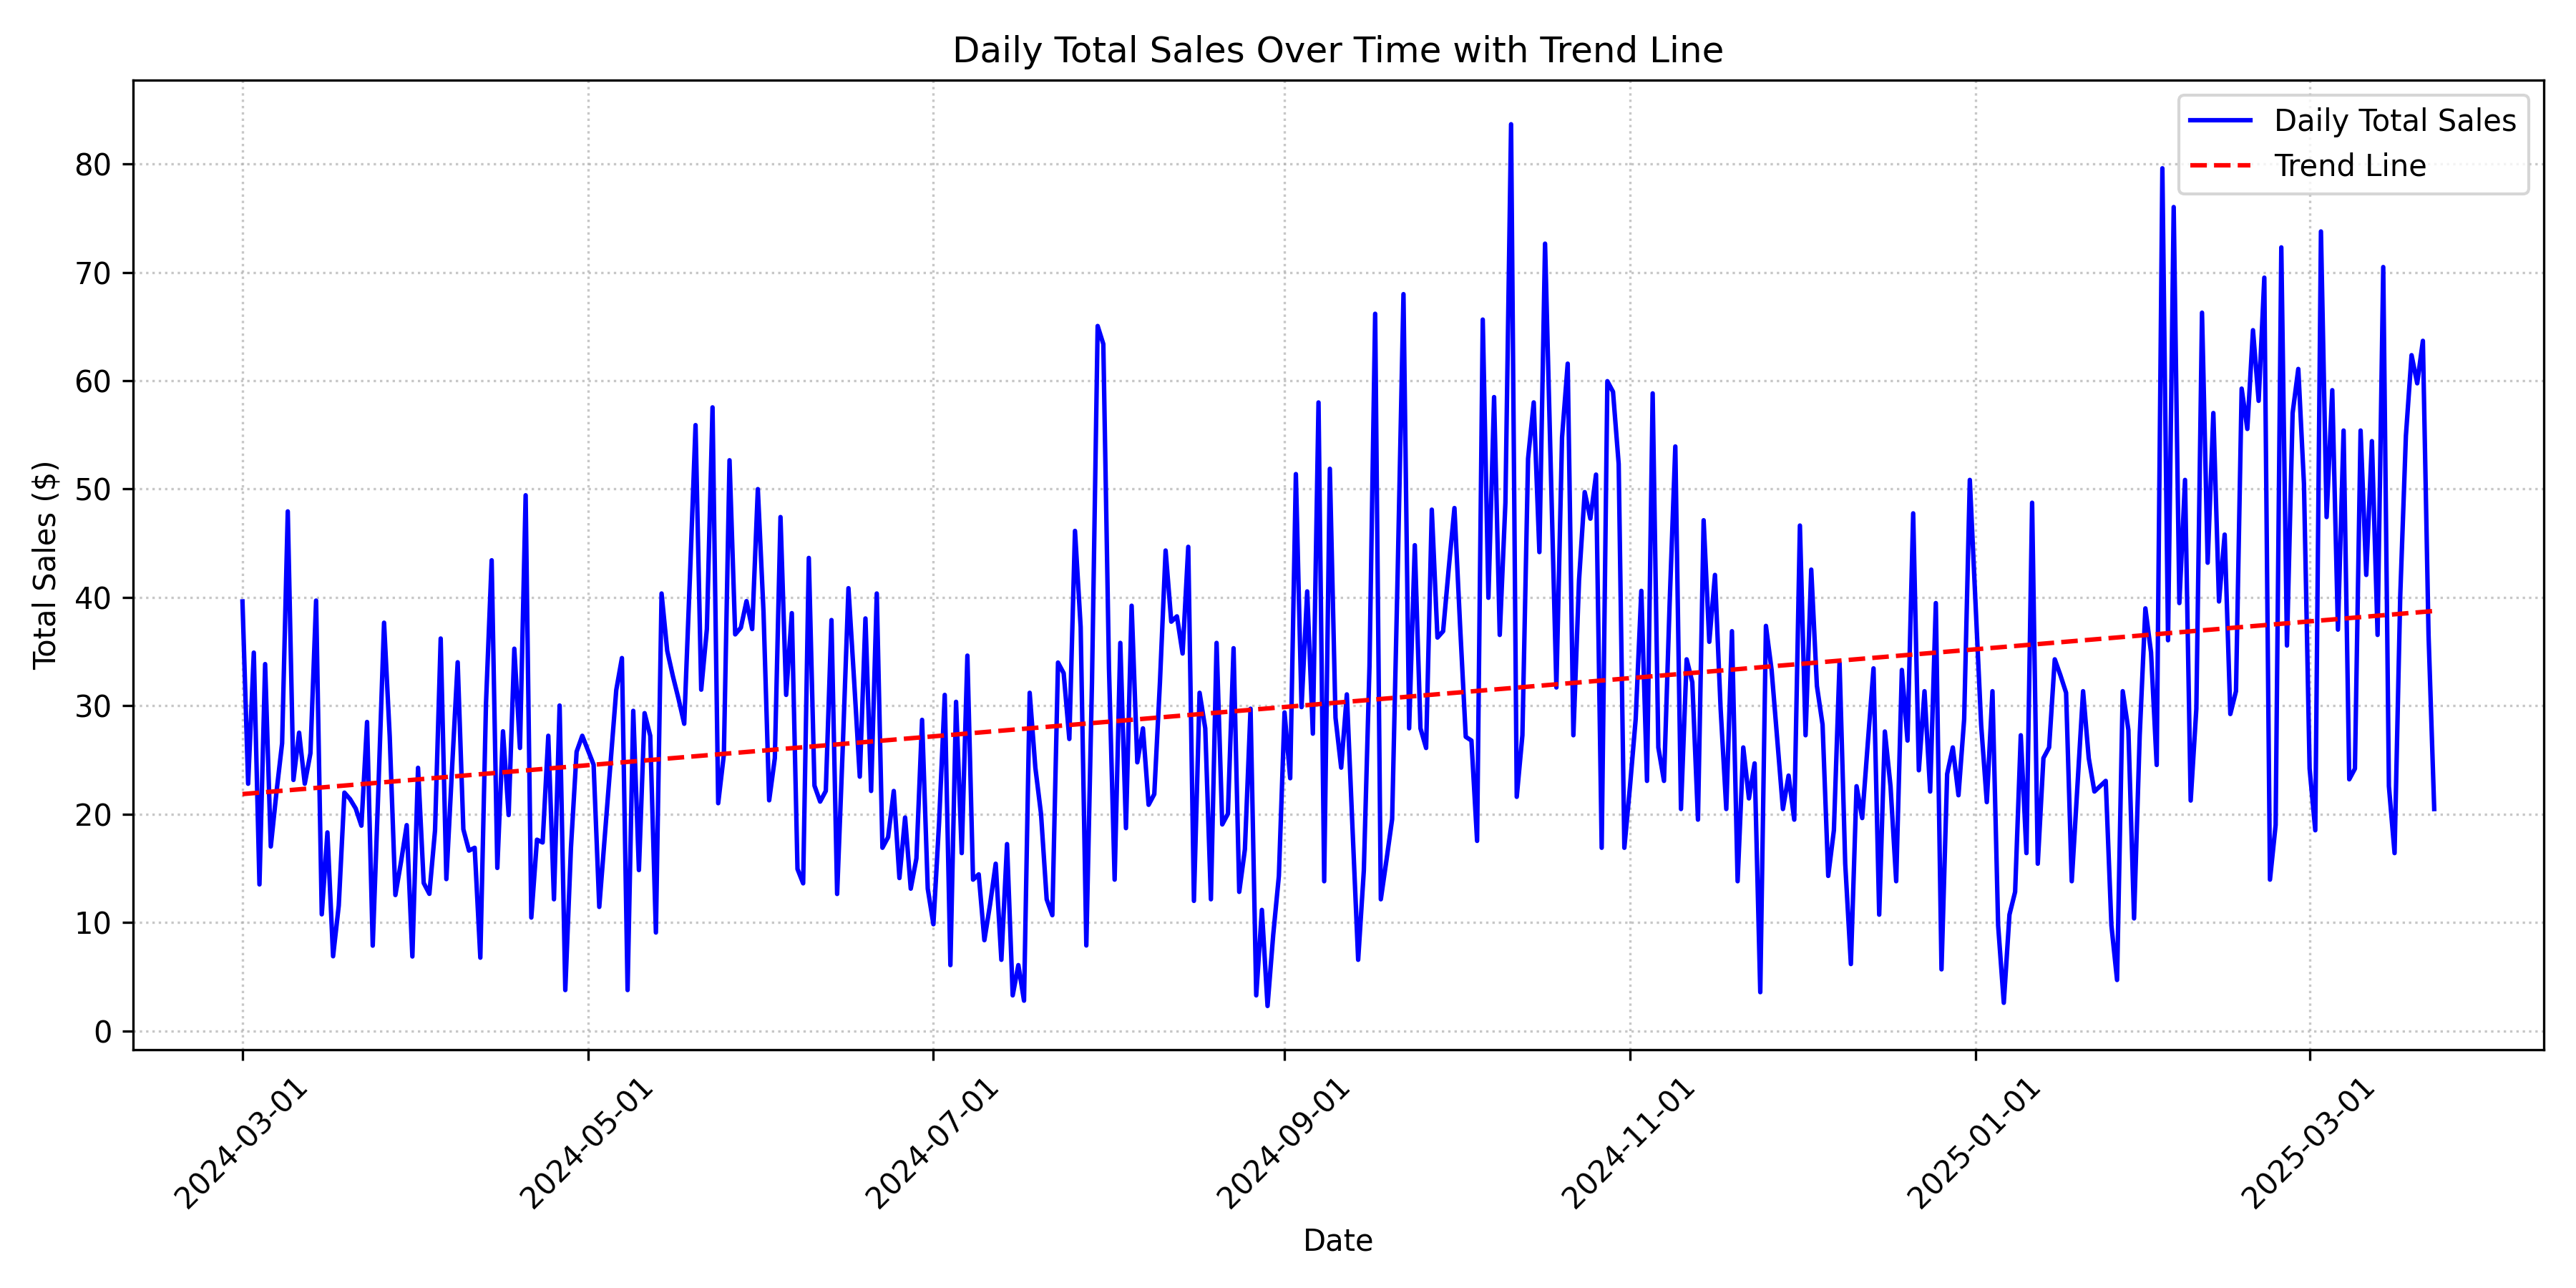


🔍 步骤 4/6: 使用 qwen3-vl-plus 进行多模态反思...
   ✅ 反思完成
   ✅ 反思完成



⚙️ 步骤 5/6: 执行改进后的代码...
   ✅ 图表 V2 生成成功
   ✅ 图表 V2 生成成功



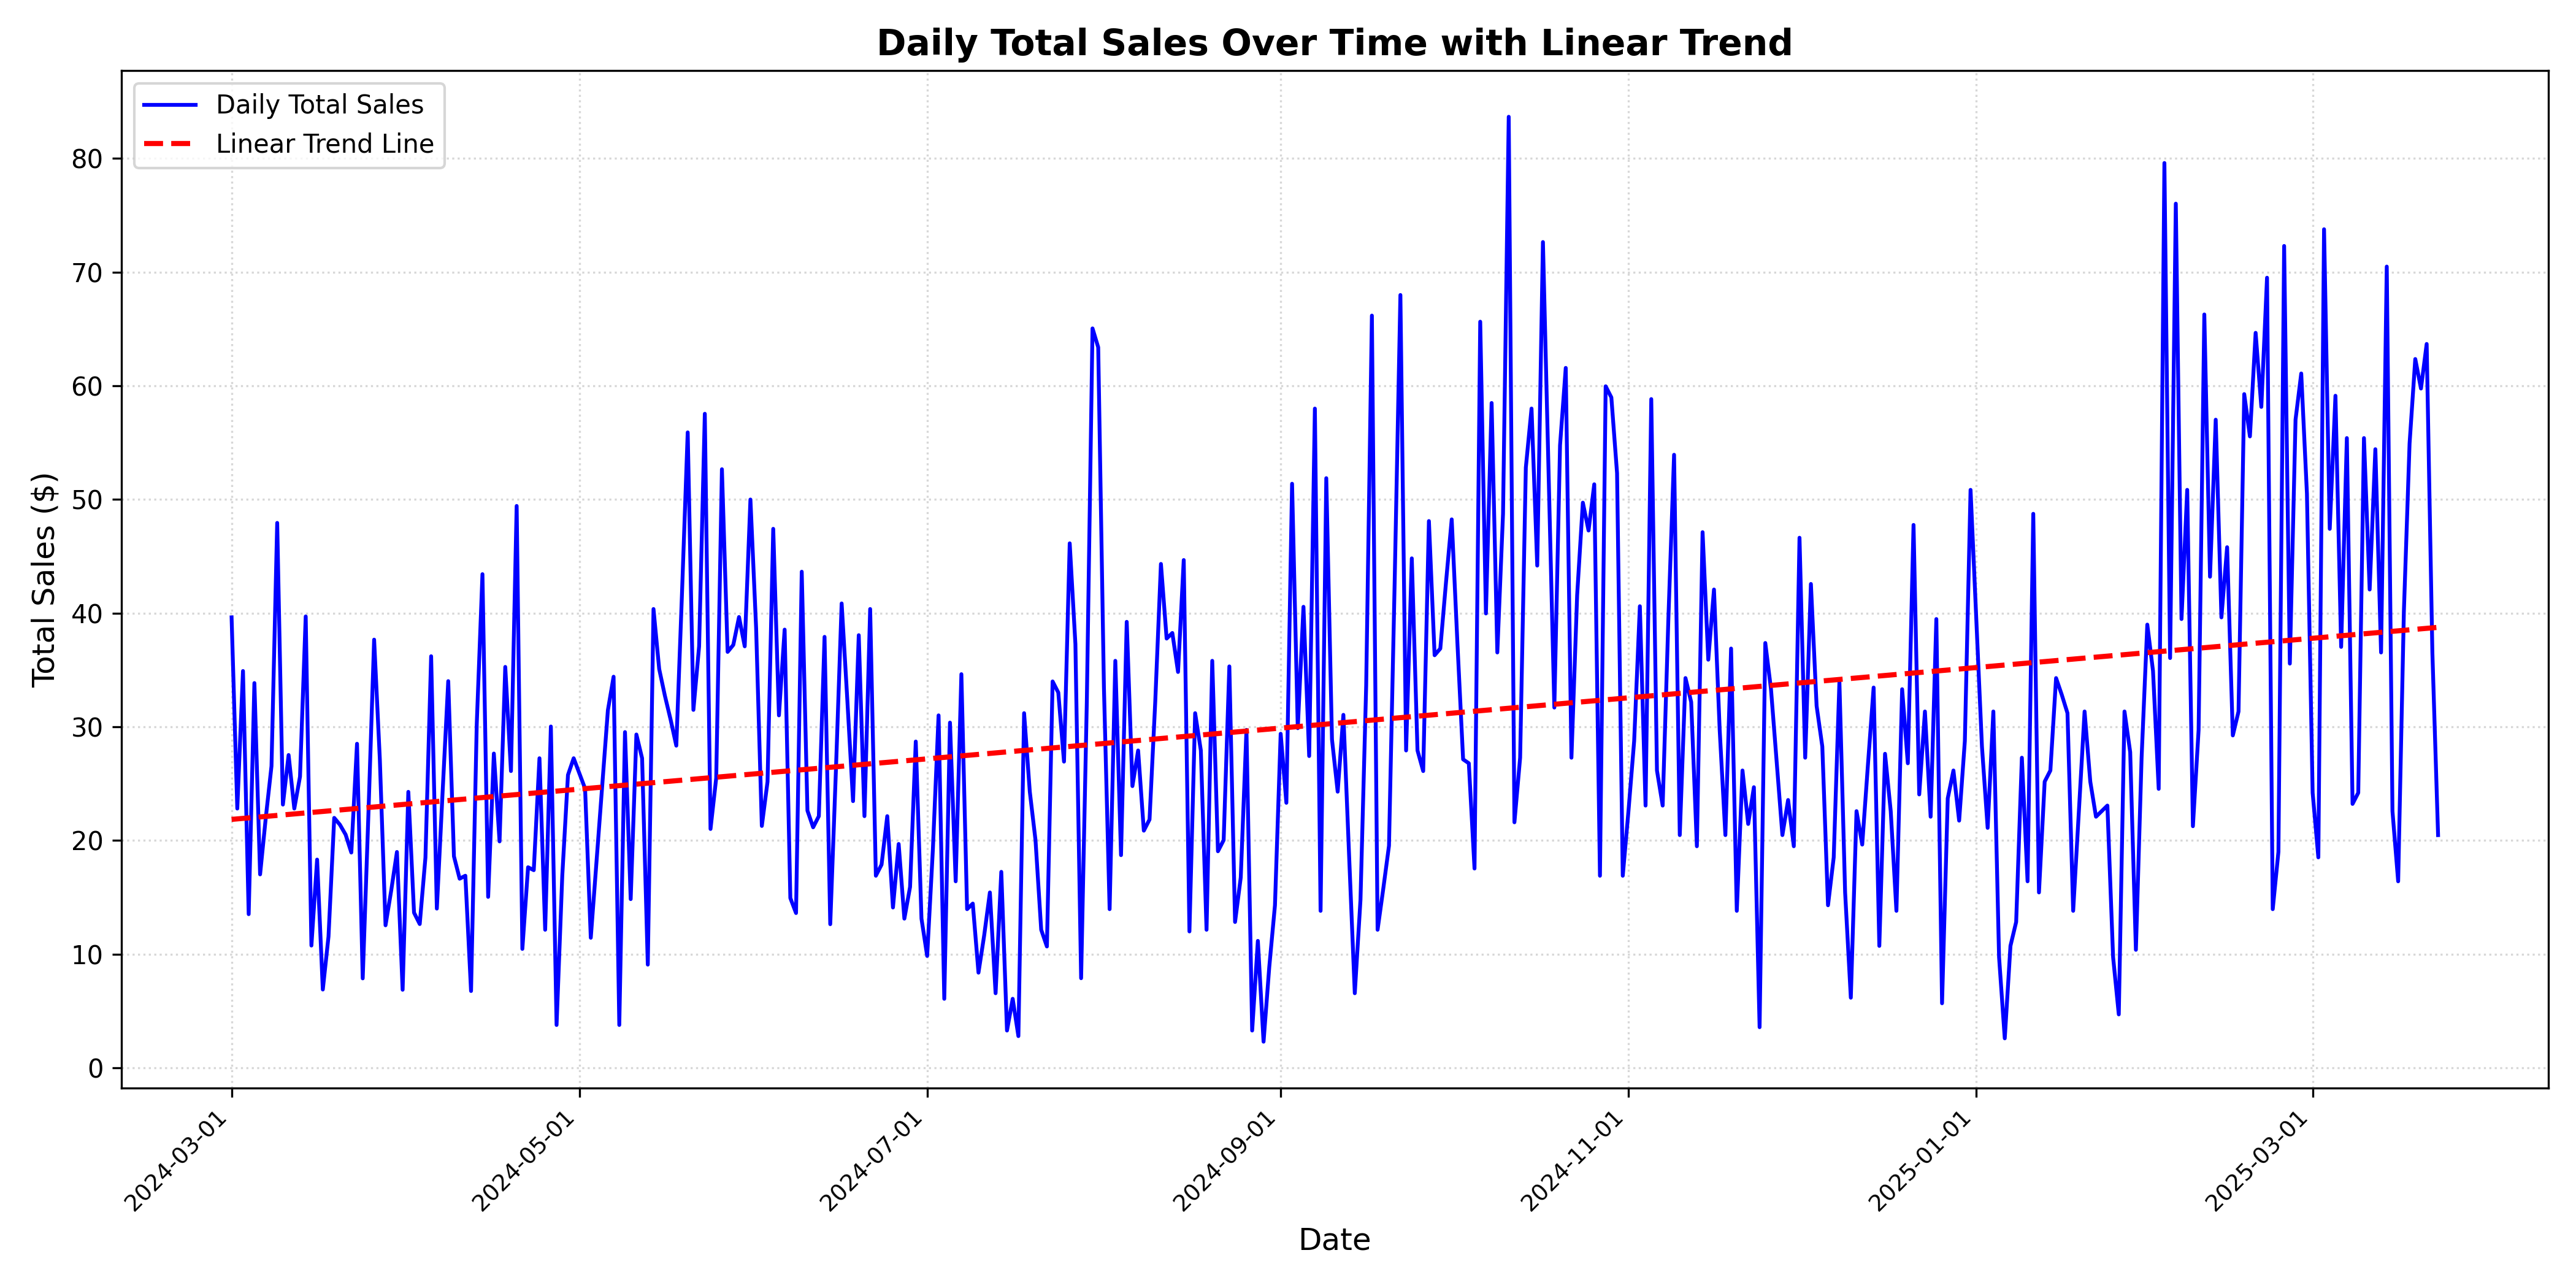


🎉 步骤 6/6: 工作流完成！

📊 对比展示



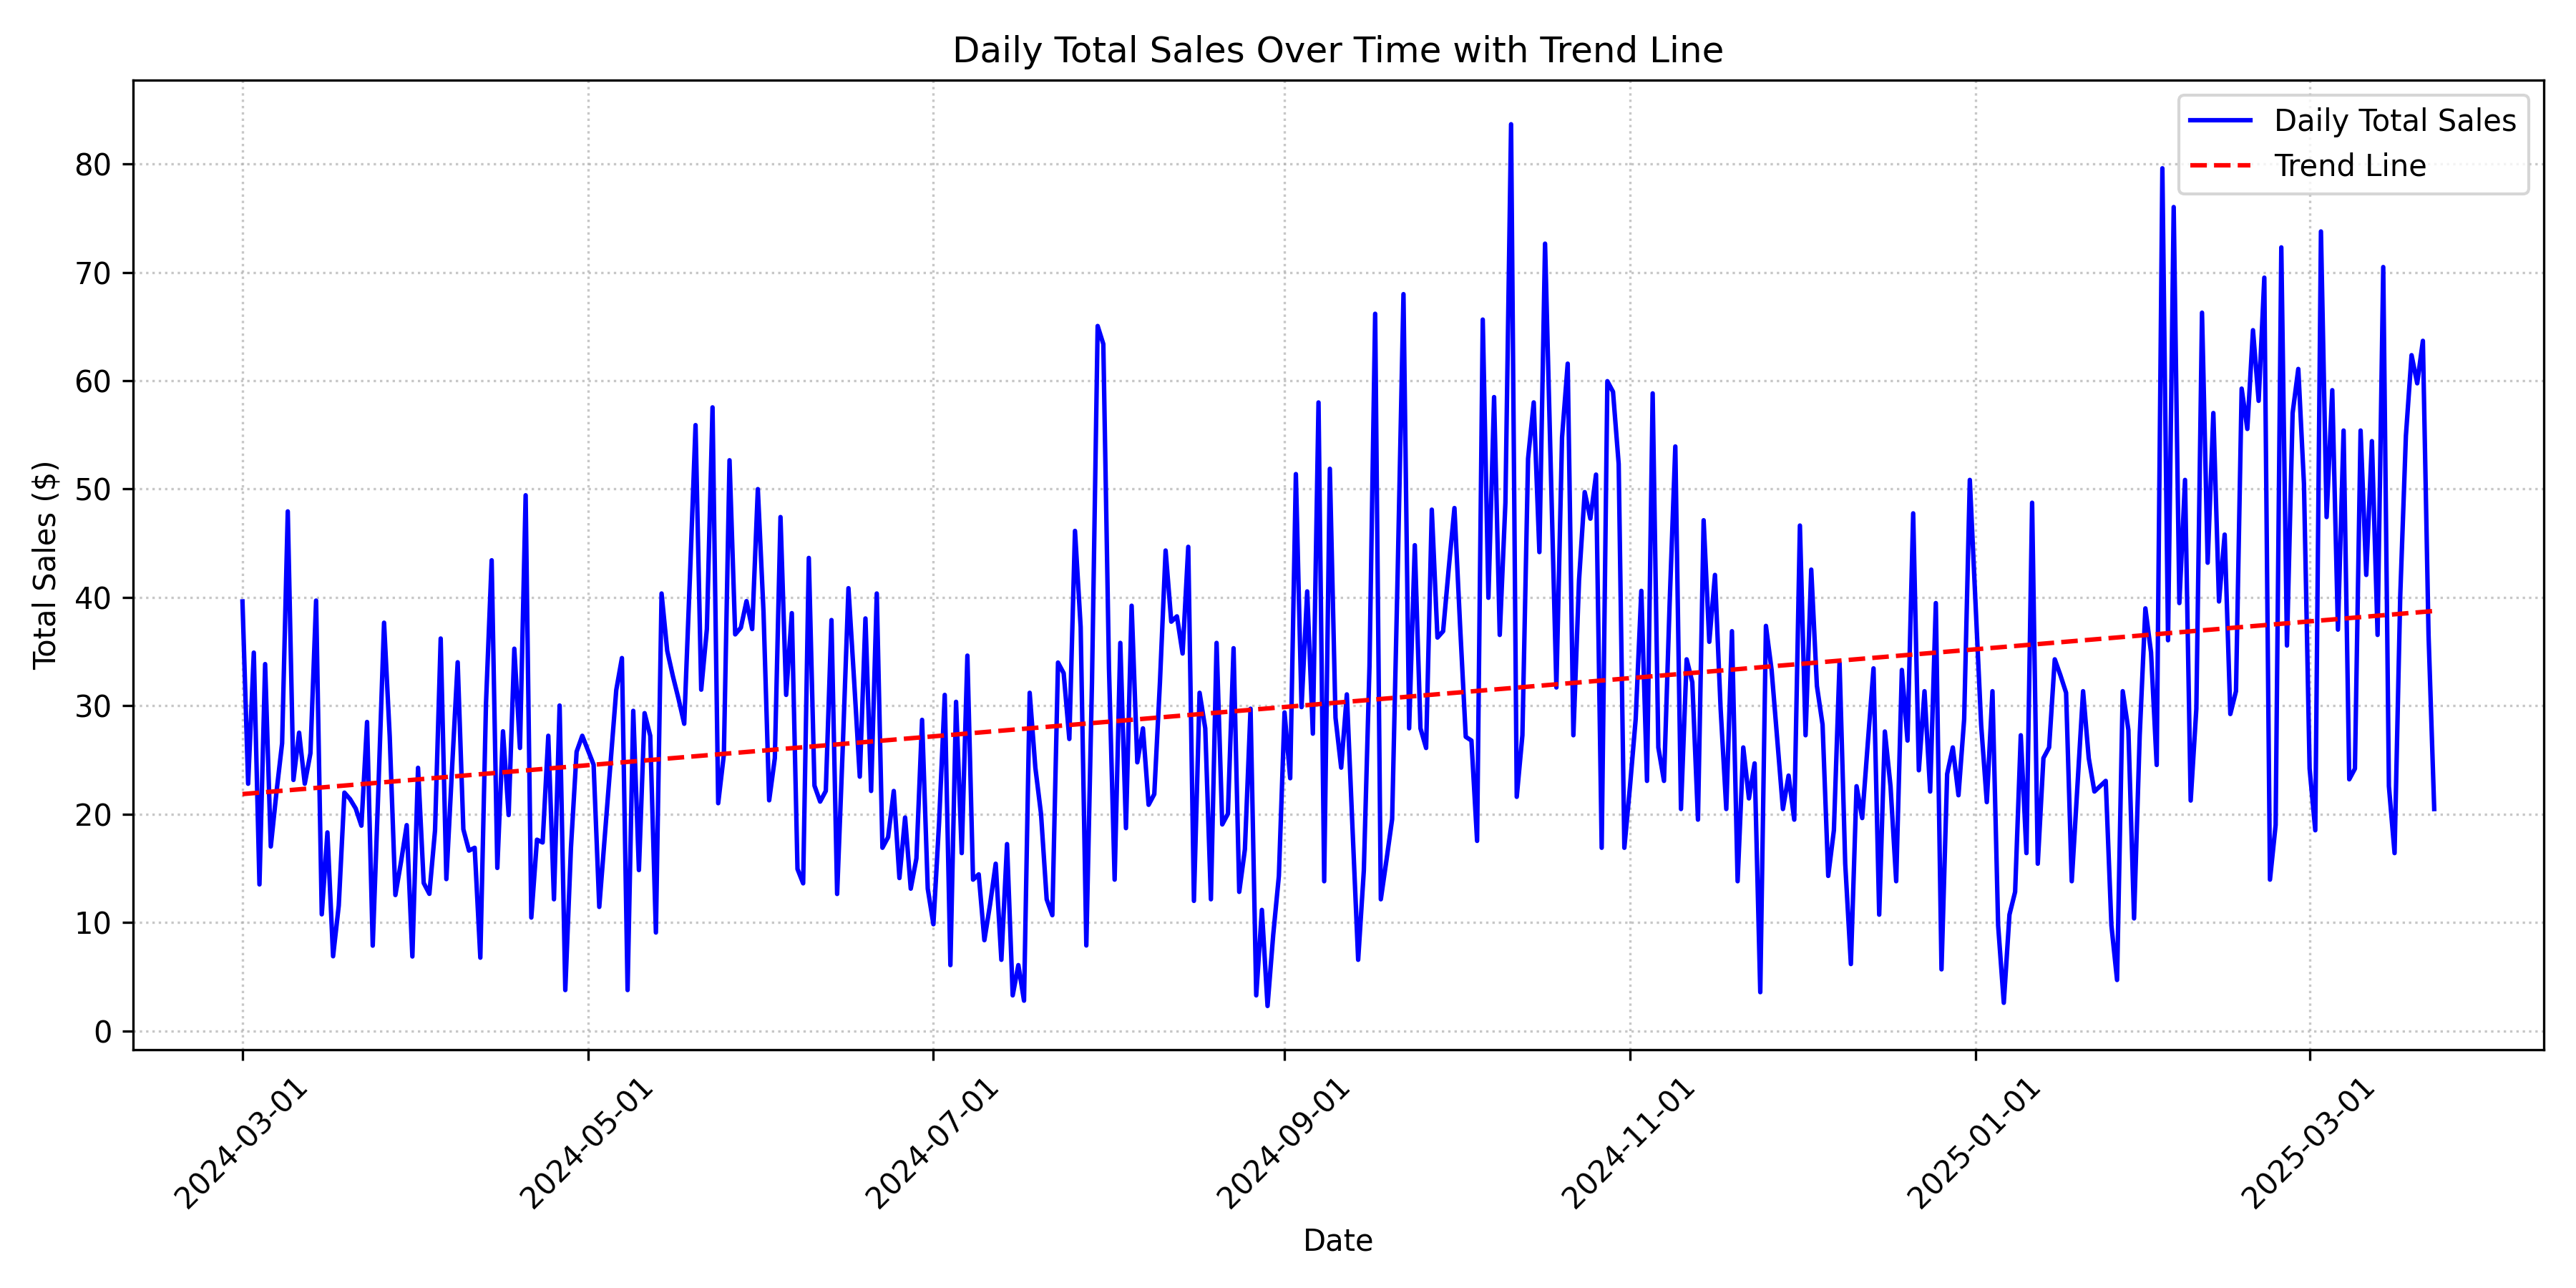
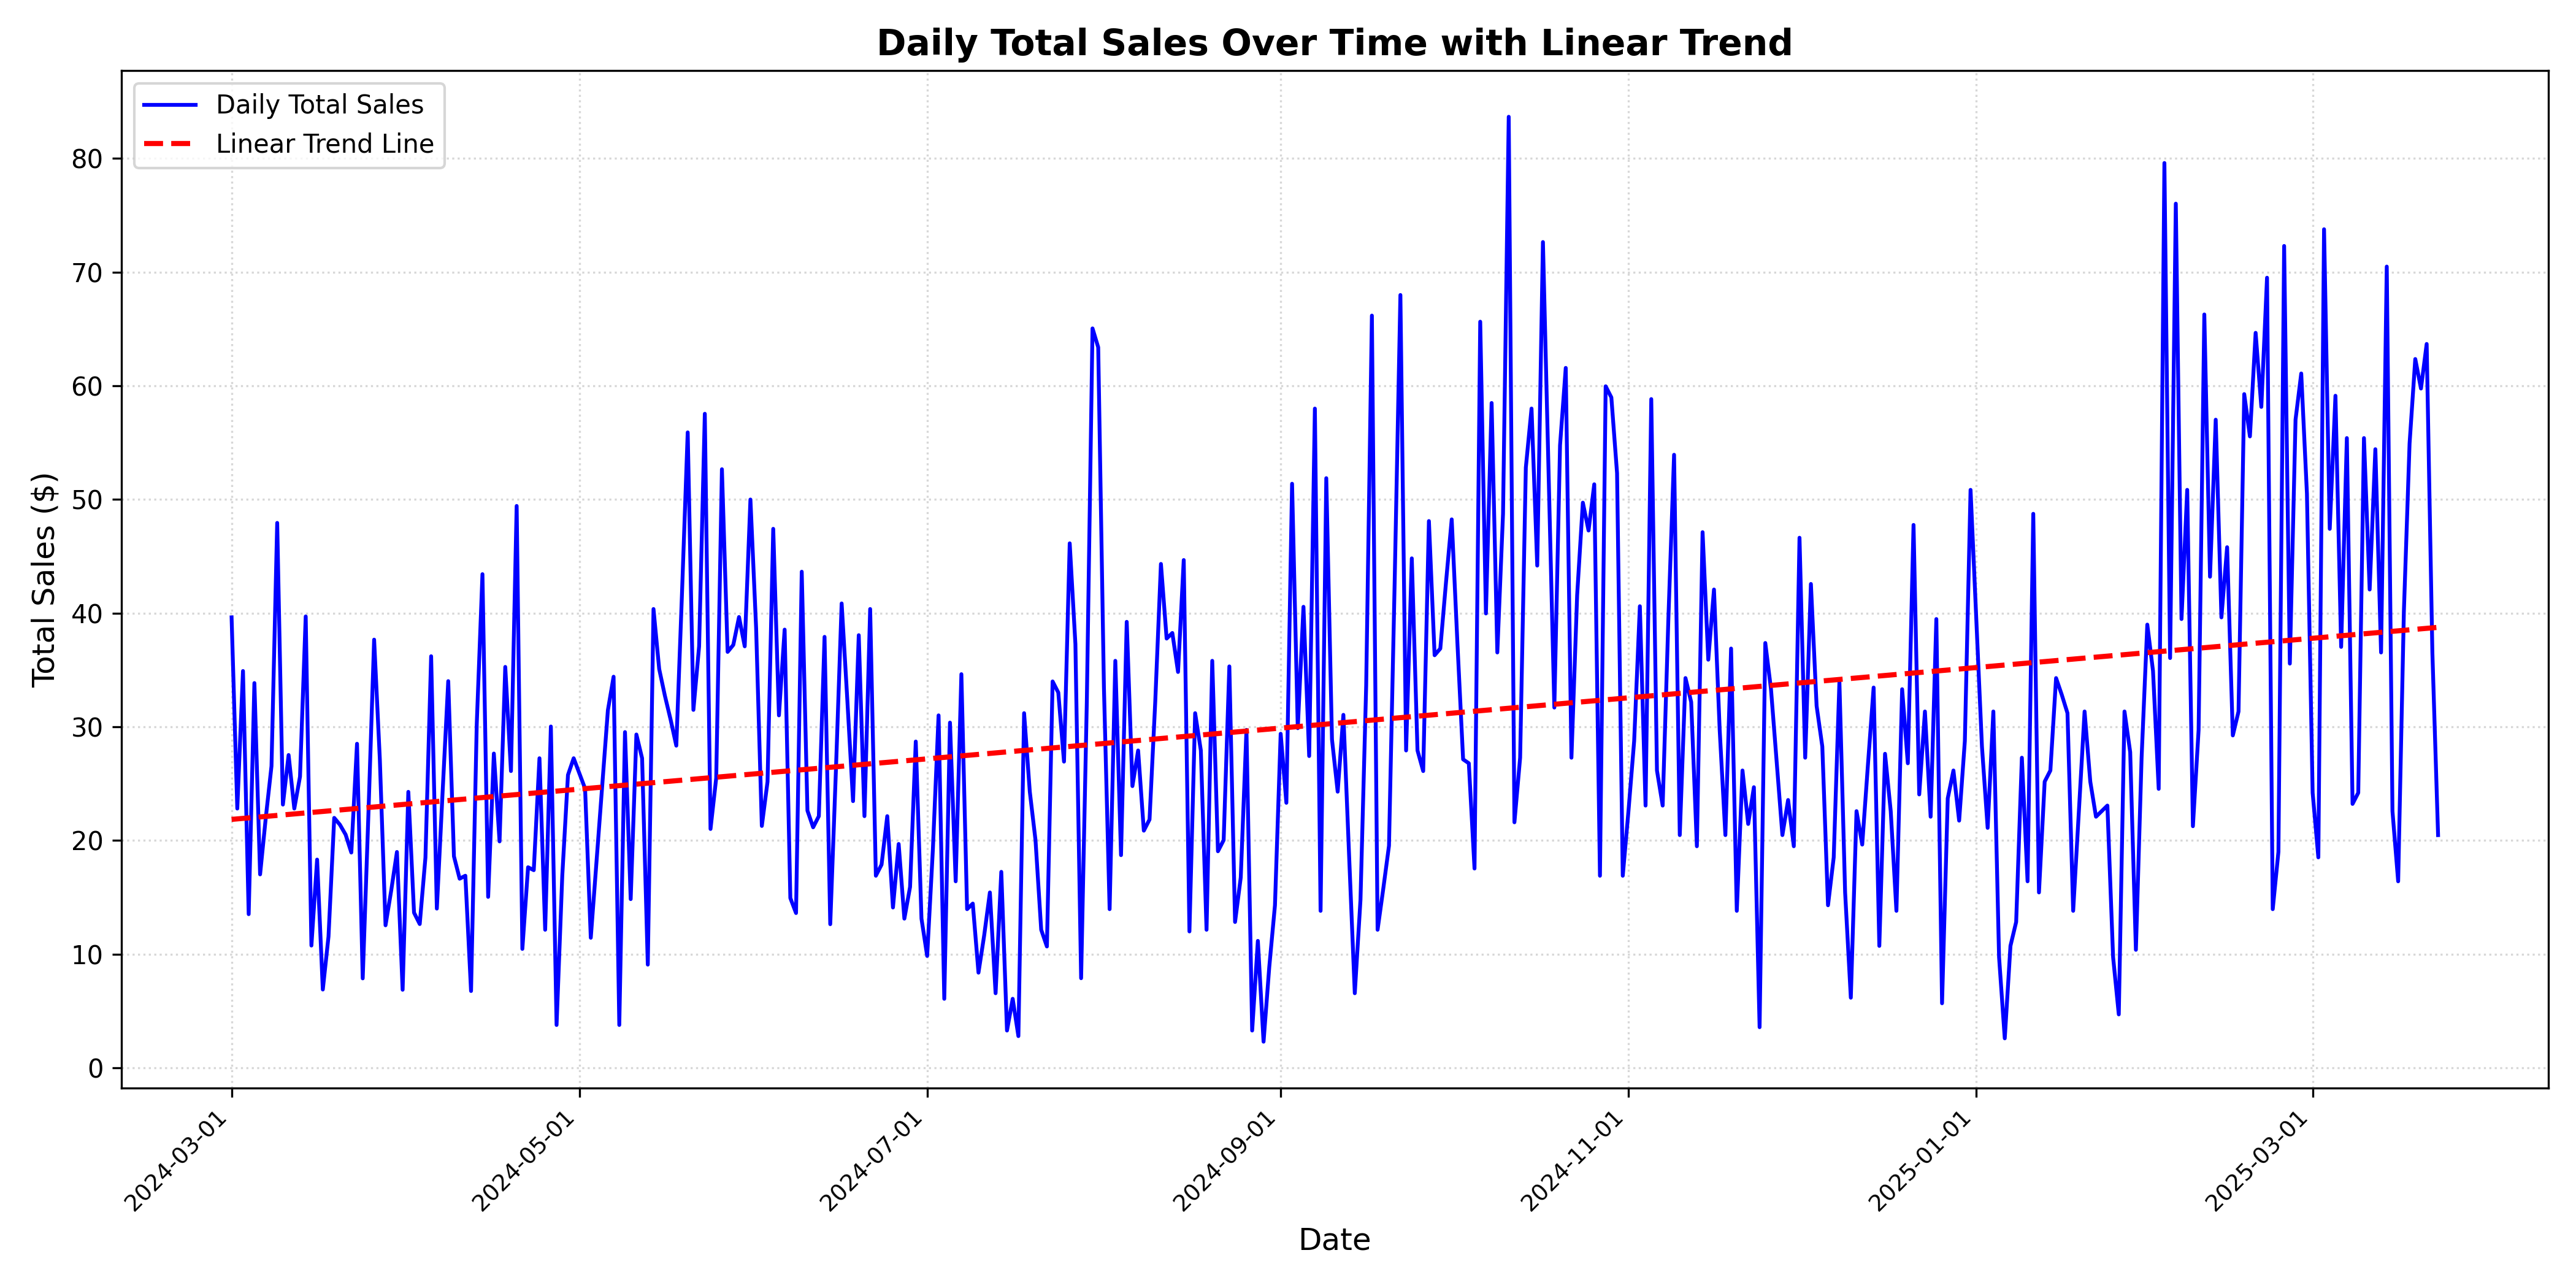


✅ 工作流执行成功！
📁 生成的文件:
   - workflow_demo_v1.png
   - workflow_demo_v2.png


In [1]:
# 从 utils 导入工作流函数
from utils import run_workflow

# 一键执行完整工作流
result = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instruction="Create a line chart showing the trend of daily total sales over time. Add a trend line.",
    generation_model="qwen3-max",      # 代码生成模型
    reflection_model="qwen3-vl-plus",         # 多模态反思模型
    image_basename="workflow_demo",    # 图片文件名前缀
    verbose=True                       # 显示详细输出
)

# 检查执行结果
if result["success"]:
    print("\n✅ 工作流执行成功！")
    print(f"📁 生成的文件:")
    print(f"   - {result['chart_v1']}")
    print(f"   - {result['chart_v2']}")
else:
    print("\n❌ 工作流执行失败")
    print("错误信息:")
    for error in result["errors"]:
        print(f"   - {error}")

## 🔧 高级用法：使用独立的高层 API 函数

如果你需要更灵活的控制，可以单独使用封装好的函数：

In [ ]:
# 导入高层 API 函数
from utils import generate_chart_code, reflect_on_image_and_regenerate

# 示例：只生成代码，不执行
custom_instruction = "Create a pie chart showing the proportion of sales by payment type (cash vs card)"
custom_schema = make_schema_text(df)

print("🎯 用户指令:", custom_instruction)
print("\n⏳ 正在生成代码...")

# 使用封装好的函数生成代码
response = generate_chart_code(
    instruction=custom_instruction,
    schema_text=custom_schema,
    model="qwen3-max",
    out_path="custom_chart.png",
    temperature=0
)

response = ensure_execute_python_tags(response)
custom_code = extract_code_from_tags(response)

if custom_code:
    print("✅ 代码生成成功！\n")
    print_html(custom_code, title="📝 生成的代码")
    
    # 你可以选择是否执行
    print("\n💡 提示: 你可以修改代码后再执行")

## 📊 批量处理：多个图表指令

演示如何使用工作流函数批量生成多个图表：

In [ ]:
# 定义多个可视化任务
tasks = [
    {
        "instruction": "Create a bar chart of top 5 most popular coffee types by quantity sold",
        "basename": "top_coffee"
    },
    {
        "instruction": "Create a line chart showing hourly sales trend throughout the day",
        "basename": "hourly_trend"
    },
    {
        "instruction": "Create a scatter plot of price vs sales volume for each coffee type",
        "basename": "price_volume"
    }
]

print(f"🚀 批量处理 {len(tasks)} 个可视化任务\n")
print("="*60)

results = []

for i, task in enumerate(tasks, 1):
    print(f"\n📊 任务 {i}/{len(tasks)}: {task['instruction'][:50]}...")
    print("-"*60)
    
    result = run_workflow(
        dataset_path="coffee_sales.csv",
        user_instruction=task["instruction"],
        generation_model="qwen3-max",
        reflection_model="glm-4v",
        image_basename=task["basename"],
        verbose=False  # 批量处理时关闭详细输出
    )
    
    if result["success"]:
        print(f"   ✅ 成功生成: {result['chart_v2']}")
    else:
        print(f"   ❌ 失败: {result['errors']}")
    
    results.append(result)

print("\n" + "="*60)
print(f"✅ 批量处理完成: {sum(1 for r in results if r['success'])}/{len(tasks)} 成功")

## 🎓 总结：三种使用方式对比

本项目提供了三种使用方式，适合不同的场景：

### 1️⃣ 手动逐步执行（教学/调试）
- ✅ **优点**: 完全可控，便于理解每个步骤
- ⚠️ **缺点**: 代码较多，需要手动管理中间变量
- 📝 **使用场景**: 学习 Agent 工作原理、调试问题

### 2️⃣ 使用高层 API 函数（灵活控制）
```python
from utils import generate_chart_code, reflect_on_image_and_regenerate

# 分步调用
code = generate_chart_code(instruction, schema, model, path)
feedback, improved_code = reflect_on_image_and_regenerate(...)
```
- ✅ **优点**: 灵活性高，可以在任意步骤插入自定义逻辑
- ⚠️ **缺点**: 需要管理数据流和错误处理
- 📝 **使用场景**: 需要自定义工作流、集成到其他系统

### 3️⃣ 一键运行完整工作流（快速使用）
```python
from utils import run_workflow

result = run_workflow(
    dataset_path="data.csv",
    user_instruction="Create a chart...",
    generation_model="qwen3-max",
    reflection_model="glm-4v"
)
```
- ✅ **优点**: 最简单，一行代码搞定，内置错误处理
- ⚠️ **缺点**: 灵活性较低
- 📝 **使用场景**: 快速验证想法、批量处理、生产环境

---

**推荐**: 
- 初学者从 **方式 1** 开始理解原理
- 有经验者直接使用 **方式 3** 提高效率
- 特殊需求使用 **方式 2** 自定义流程

## 📚 API 参考

### `run_workflow()` 完整参数说明

```python
run_workflow(
    dataset_path: str,           # 必需：CSV 数据文件路径
    user_instruction: str,       # 必需：用户绘图指令
    generation_model: str,       # 必需：代码生成模型
    reflection_model: str,       # 必需：多模态反思模型
    image_basename: str = "chart",  # 可选：图片文件名前缀
    verbose: bool = True         # 可选：是否显示详细输出
) -> dict
```

### 返回值结构

```python
{
    "success": bool,              # 是否成功执行
    "df": pd.DataFrame,           # 加载的数据
    "schema_text": str,           # 数据 Schema
    "code_v1": str,               # 初始代码
    "chart_v1": str,              # V1 图片路径
    "feedback": str,              # 反思反馈
    "code_v2": str,               # 改进代码
    "chart_v2": str,              # V2 图片路径
    "errors": List[str]           # 错误信息列表
}
```

### 支持的模型

**代码生成模型** (generation_model):
- `qwen3-max` - 通义千问（推荐，代码能力强）
- `gpt-4o` - OpenAI GPT-4o
- `glm-4` - 智谱 GLM-4
- `deepseek-chat` - DeepSeek Chat
- `moonshot-v1-32k` - Kimi

**多模态反思模型** (reflection_model):
- `glm-4v` - 智谱 GLM-4V（推荐，中文友好）
- `qwen-vl-plus` - 通义千问 VL Plus
- `gpt-4o` - OpenAI GPT-4o
- `claude-3-5-sonnet-20241022` - Anthropic Claude 3.5 Sonnet

---
*完整文档请参阅 `docs.md` 和 `spec.md`*